```python
            "delta":(  2,  4),
            "theta":(  4,  8),
            "alpha":(  8, 12),
            "beta": ( 15, 30),
            "gamma":( 30,150),
            "low gamma": (30, 80),
            "high gamma":(80,150),
            "lowpass":(1,200),
            "highpass":(200,500)
```

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import EEGAnalysis as ea

# 目录

- Compact Data
    - [compact data import](#compact-data-import)
    - [total power](#total-power)
    - [power结果的可视化](#power结果的可视化)
    - [channel preview](#channel-preview)
    - [ITPC](#ITPC)
    - [小结](#随堂思考？？😂)
- Split Data
    - [导入数据](#导入数据)
    - [ERP可视化](#ERP可视化)
    - [小波变换](#小波变换)
    - [total power及其可视化](#total-power及其可视化)
    - [ITPC及其可视化](#ITPC及其可视化)
    

* 按`shift+enter`运行代码块

---
# Compact Data

## compact data import

compact data在`Data/patientname/EEG/Compact/`里面，
`targetexp`就是需要导入的文件的文件名。例如：对于文件`180901-3-10.mat`，它的`targetexp`就是`180901-3-10`

In [2]:
datadir = "../Data"
resultdir = "../Result"
patientName = "Chen Zhou"
fs = 2000
roi = None  # region of interest，如果设为None则自动设置为(-2, ITI)

targetexp = "180901-3-10"  # 需要导入的文件的文件名

datacontainer = ea.CompactDataContainer(
    datadir, resultdir, patientName, 
    targetexp, fs)

`ea.CompactDataContainer`返回一个打包了的数据集，里面主要有
- channels：2维数组，每一行为一个channel的原始数据点(uV)
- times：1维数组，每一个原始数据点所对应的时刻(sec)
- markers：一个字典，每项为一个1维数组，为marker的时刻点(sec)
- roi：一个tuple{float, float}，设置了在切割时的范围(sec)
- fs：一个浮点数，采样频率(Hz)

例如：要调用`datacontainer`的`channels`，只要写`datacontainer.channels`即可。

In [3]:
datacontainer.channels

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.74576187e+01, -4.81457977e+01, -4.98927002e+01, ...,
         2.86122074e+01,  2.65741501e+01,  2.76328812e+01],
       [-3.54521751e+01, -3.67229614e+01, -3.76969223e+01, ...,
        -3.56469688e+01, -3.46637306e+01, -3.39865952e+01],
       ...,
       [ 1.70543663e-05,  1.70543663e-05,  1.70543663e-05, ...,
         1.70543663e-05,  1.70543663e-05,  1.70543663e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

## total power

在做total power之前需要计算小波变换后的复数形式。

1. 选择目标通道号（从0开始记）
2. 按marker切割数据成2维数组，每行为对应marker所在roi的原始数据
3. 设定需要计算的频率范围
4. 进行小波变换。在这里，先进行了切割再做了小波变换，为了消除边界效应，将`reflection`这只为`True`。
「另一种策略是先进行小波变换再做切割，则不存在边界效应；你可以自己尝试一下」
5. 将复数形式转化为power；

In [4]:
chidx = 108  # 1. 选择进行计算的channel号，从0开始记
ch_split = datacontainer.group_channel_by_marker(chidx, "grating")  # 2. 依照grating的marker来切割数据

frange = np.logspace(np.log10(1), np.log10(200), 40)  # 3. 设置频率范围，这里采用了logspace， 从1到200，取40个点
%time dwt_result = ea.dwt.dwt(ch_split, fs, frange, reflection=True)  # 4. 小波变换
# pxx = ea.power.dwt_power(dwt_result, fs, baseline=(0.5,1.5))  # baseline normalization
pxx = ea.power.dwt_power(dwt_result, fs)  # 5. 转化为power，并做zscore归一化处理

CPU times: user 4.44 s, sys: 484 ms, total: 4.92 s
Wall time: 4.99 s


- 当不知道具体的函数接受哪些参数时，可以运行`help(funcname)`来查询文档

In [5]:
help(ea.dwt.dwt)

Help on function dwt in module EEGAnalysis.decomposition.dwt:

dwt(data, fs, frange, wavelet=<function morlet at 0x10e839d08>, reflection=False)
    wavelet tranform decomposition.
    
    Syntax: Dwt = dwt(data, fs, frange, wavelet, reflection)
    
    Keyword arguments:
    data       -- (numpy.ndarray) 1D or 2D array. for 2D array, columns as
                  observations, rows as raw data.
    fs         -- (int) sampling rate
    frange     -- (numpy.ndarray) target frequencies
    wavelet    -- (function) wavelet function [default: morlet]
    reflection -- (bool) perform data reflection, to compensate the edge effect
                  [default: False]
    
    Return:
    Dwt        -- (numpy.ndarray, dtype="complex") wavelet decomposition result



### power结果的可视化

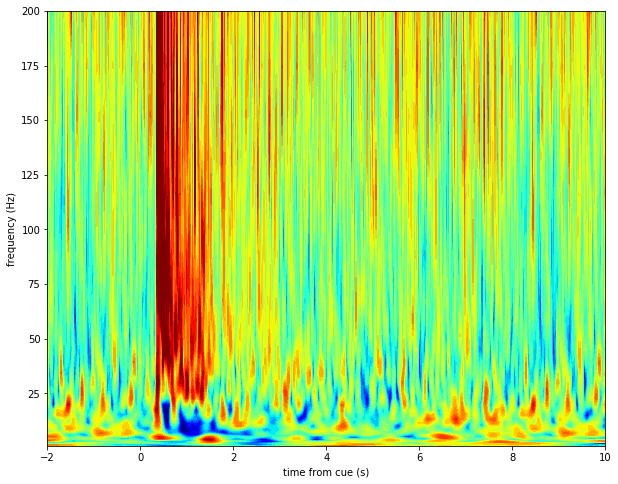

In [6]:
plt.figure(figsize=(10,8))  # 设置图像大小为 (10*8) inches
tspec = np.linspace(-2,10,np.size(pxx,1))  # 计算x轴的各个点所对应的时间点
plt.contourf(tspec, frange, pxx, 50, cmap=plt.get_cmap("jet"))  # 自动拟合成heatmap，平滑度为50
plt.xlabel("time from cue (s)")  # 设置x轴的名称
plt.ylabel("frequency (Hz)")  # 设置y轴的名称
# plt.title("180901-3-10-channel109")  # 设置标题
plt.clim([-3,3])    # 设置colorbar的取值范围
plt.show()  # 显示图片
plt.close('all')  # 将图片从内存中清除

## channel preview
预览某个channel的一段时间内的power值

In [7]:
chidx = 99  # 选取目标的channel编号
trange = (170.0, 210.0)  # 设置目标的时间段，单位为sec，注意：不要超过实际数据的最大范围

starter = int(trange[0] * fs)
gap = int((trange[1]-trange[0]) * fs)
target_ch = datacontainer.channels[chidx, starter:starter+gap]  # 获取目标的原始数据片段

frange = np.logspace(np.log10(1), np.log10(200), 40)  # 设置目标的频率范围
%time dwt_result = ea.dwt.dwt(target_ch, fs, frange, reflection=False)  # 进行小波变换，这时由于片段时间足够长，边界效应可以忽略，reflection可设为False

pxx = ea.power.dwt_power(dwt_result, fs)  # 转化为power，并做zscore归一化处理

CPU times: user 428 ms, sys: 129 ms, total: 557 ms
Wall time: 562 ms


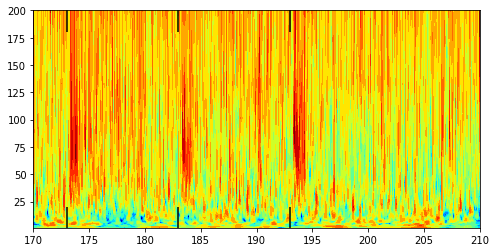

In [8]:
# 可视化
plt.figure(figsize=(8,4))
tspec = np.linspace(trange[0],trange[1], np.size(pxx, 1))
plt.contourf(tspec, frange, pxx, 40, cmap=plt.get_cmap("jet"))

plt.vlines(datacontainer.markers["grating"][0][0][0, :], 180, 200)  # 划上 上方的grating标记
plt.vlines(datacontainer.markers["grating"][0][0][0, :], 1, 20)  # 划上 下方的grating标记

# 随堂练习？
# 画上entrain的标记
# ...

plt.xlim(trange)  # 设置x轴的范围
plt.clim([-3,3])
plt.show()
plt.close()

## ITPC

相位分析

In [9]:
chidx = 108  # 同样选择channel
ch_split = datacontainer.group_channel_by_marker(chidx, "grating")  # 再做切割

frange = np.logspace(np.log10(1), np.log10(200), 40)  # 设置频率范围
%time dwt_result = ea.dwt.dwt(ch_split, fs, frange, reflection=True)  # 做小波变换

itpc = ea.phase.dwt_itpc(dwt_result)  # 计算ITPC

CPU times: user 4.45 s, sys: 504 ms, total: 4.95 s
Wall time: 5.07 s


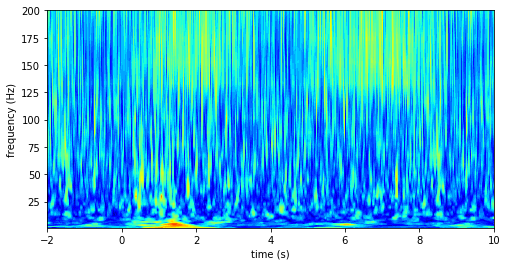

In [10]:
# 可视化
plt.figure(figsize=(8,4))
plt.contourf(np.linspace(-2,10, np.size(itpc, 1)), frange, itpc, 40, cmap=plt.get_cmap("jet"))

plt.xlabel("time (s)")
plt.ylabel("frequency (Hz)")
plt.clim([0,1])

plt.show()
plt.close()

## 随堂思考？？😂

对于大部分的数据和分析，都是基于小波变换得到的复数形式；而计算小波变换是这里所有操作中最费时间的一项。

计算时，可以先对整一段原始数据进行小波变换，再依据marker来对数据切割；
也可以先依据marker来对数据切割，再进行小波变换。
两者没有本质的区别，但由于后者的时间窗较小，边界效应会比较明显；
这可以通过数据反转(reflection)来抵消一部分边界效应，但会使得计算量变成原来的3倍。

你可以尝试对以上的分析先对进行小波变换，再依据marker来对数据切割(可能需要自己写一个或者修改已有的切割函数)。

---
# split data

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

import EEGAnalysis as ea
import numpy as np

## 导入数据

split data（即位于`SgCh`文件夹里的数据）和之前的Compact数据相比，就有比较大的区别了

但导入的过程基本相同，甚至更为简单：

In [13]:
datacontainer_split = ea.container.SplitDataContainer(
    sgchdir="..//Data/Chen Zhou/EEG/SgCh",  # SgCh文件夹所在的路径
    chidx=35,  # 目标的channel号（从0记）
    fs=2000,  # 采样频率
    marker_bias = None  # 你整理的不同文件marker的bias csv文件，
                        # 把csv文件放在SgCh文件夹里，这里写上csv文件的文件名（包括后缀名）
)  

`ea.container.SplitDataContainer`返回一个打包了的数据集，里面主要有
- ch_erp：字典，每项为2维数组，每行为对应marker及roi的原始数据； roi取(-2, iti)

例如：要调用`datacontainer_split`的`ch_erp`，只要写`datacontainer_split.ch_erp`即可。

In [6]:
np.shape(datacontainer_split.ch_erp["5"])

(420, 14000)

## ERP可视化

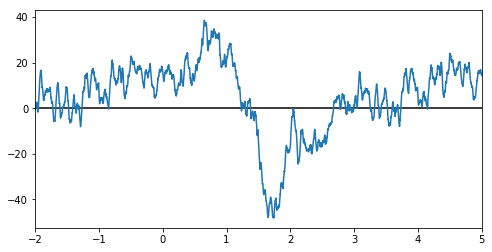

In [7]:
erp = np.mean(datacontainer_split.ch_erp["5"], 0)

plt.figure(figsize=(8,4))
tspec = np.linspace(-2, 5, 14000)
plt.plot(tspec, erp) 
plt.hlines(0, -2, 5)
plt.xlim([-2, 5])
plt.show()

## 小波变换
对于Split Data的小波变换，数据已经是切割好了的。

由于有400+的片段，用原来单线程的方式需要大约42秒；
因此采用了Dask模块(在powershell里输入`python -m pip install dask`进行安装)来实现并行运算，进行提速。

In [8]:
frange = np.logspace(np.log10(1), np.log10(80), 10)
%time kk = ea.decomposition.dwt.da_dwt(data=datacontainer_split.ch_erp["5"], frange=frange, fs=2000, reflection=True)

CPU times: user 59.2 s, sys: 7.91 s, total: 1min 7s
Wall time: 28.6 s


In [4]:
%time kk_ = ea.decomposition.dwt.dwt(data=datacontainer_split.ch_erp["5"], frange=frange, fs=2000, reflection=True)

CPU times: user 18.9 s, sys: 11.9 s, total: 30.7 s
Wall time: 42.4 s


## total power及其可视化

CPU times: user 974 ms, sys: 1.45 s, total: 2.43 s
Wall time: 2.9 s


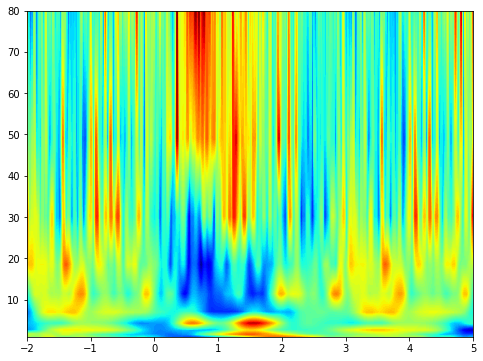

In [9]:
%time kk_totalpwr = ea.power.dwt_power(kk, fs=2000, zscore=True)
plt.figure(figsize=(8,6))
plt.contourf(np.linspace(-2,5,14000), frange, kk_totalpwr, 80, cmap=plt.get_cmap("jet"))
plt.show()

## ITPC及其可视化

CPU times: user 1.89 s, sys: 2.4 s, total: 4.29 s
Wall time: 6.37 s


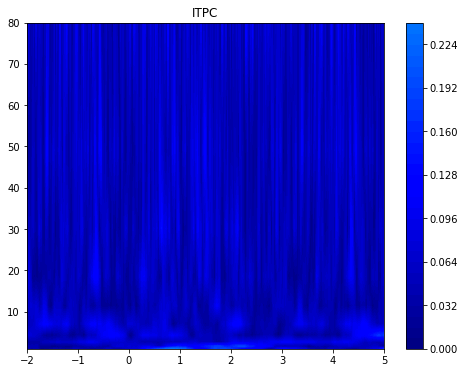

In [10]:
%time kk_itpc = np.abs(np.sum(kk/np.abs(kk), 1)) / 420  # 计算itpc值

plt.figure(figsize=(8,6))
plt.contourf(np.linspace(-2,5,14000), frange, kk_itpc, 30, cmap=plt.get_cmap("jet"))
plt.clim([0,1])
plt.colorbar(extend="both")
plt.title("ITPC")
plt.show()